# Stock Prediction Model Training

In the "RetrievalAugmentedPredictionModel" notebook we created our model that can be used to make efficient stock prediction for new business ideas.
At first we create our Dataset class that will be used to train the model:


### Load Libraries and Set Up Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from PredictionModel.RetrievalAugmentedPredictionModel import RetrievalAugmentedPredictionModel
from RetrievalSystem.RetrievalSystem import RetrievalSystem
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

### Testing

In [2]:
#

# hidden_dim = 128  # Example hidden size
# historical_scaler = joblib.load("/kaggle/input/scaler/historical_scaler.pkl")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_save_path = "/kaggle/input/trainedmodel2/best_model.pth"
# model = StockPerformancePredictionModel(3, 12, hidden_dim, 12)

# # Load the model on the device where you want to use it
# model.load_state_dict(torch.load(model_save_path, map_location=device))
# model.to(device)

# model.eval()

# with torch.no_grad():
#     predictions = model(
#         idea=["Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instruments; atomic absorption instruments; microwave plasma-atomic emission spectrometry instruments; inductively coupled plasma optical emission spectrometry instruments; raman spectroscopy; cell analysis plate based assays; flow cytometer; real-time cell analyzer; cell imaging systems; microplate reader; laboratory software; information management and analytics; laboratory automation and robotic systems; dissolution testing; and vacuum pumps, and measurement technologies. The Diagnostics and Genomics segment focuses on genomics, nucleic acid contract manufacturing and research and development, pathology, companion diagnostics, reagent partnership, and biomolecular analysis businesses. The Agilent CrossLab segment provides GC and LC columns, sample preparation products, custom chemistries, and laboratory instrument supplies; and offers services portfolio, including repairs, parts, maintenance, installations, training, compliance support, software as a service, asset management, and consulting services. The company markets its products through direct sales, distributors, resellers, manufacturer's representatives, and electronic commerce. Agilent Technologies, Inc. was incorporated in 1999 and is headquartered in Santa Clara, California."],
#         use_auxiliary_inputs=False
#     )

# print(predictions)
# nan_tensor = torch.full((1, 12), float('nan'), device=predictions.device) # Expand zeros_tensor to 2D (1, 12)
# right = [0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962,0.0002258687415962]
# right_tensor = torch.tensor(right, device=predictions.device)
# right_tensor = right_tensor.unsqueeze(0)

# # Now concatenate along dim=1
# stock_market_prediction = torch.cat((right_tensor, predictions), dim=1)

# # Ensure the tensor is detached from the computation graph before converting to numpy
# predictions_np = stock_market_prediction.detach().cpu().numpy()
# prediction_historical = historical_scaler.inverse_transform(predictions_np)
# print(prediction_historical[0])

# # Assuming target_series and pred_series are created here...
# target_series = pd.Series(prediction_historical[0])

# sns.set_style("darkgrid")
# fig = plt.figure(figsize=(10, 6))  # Add figure size for clarity

# plt.subplot(1, 2, 1)
# ax = sns.lineplot(x=target_series.index, y=target_series.values, label="Data", color='royalblue')
# ax.set_title('Stock price', size=14, fontweight='bold')
# ax.set_xlabel("Days", size=14)
# ax.set_ylabel("Cost (USD)", size=14)

# plt.show()  # Ensure the plot appears




### Load Scalers

In [3]:
# Load the scaler
percent_change_scaler = joblib.load('../Dataset/Data/Scaler/% Change_scaler.pkl')
beta_scaler = joblib.load('../Dataset/Data/Scaler/beta_scaler.pkl')
company_age_scaler = joblib.load('../Dataset/Data/Scaler/Company_Age_scaler.pkl')
country_scaler = joblib.load('../Dataset/Data/Scaler/Country_scaler.pkl')
current_ratio_scaler = joblib.load('../Dataset/Data/Scaler/current_ratio_scaler.pkl')
ebit_scaler = joblib.load('../Dataset/Data/Scaler/ebit_scaler.pkl')
ebitda_margins_scaler = joblib.load('../Dataset/Data/Scaler/ebitda_margins_scaler.pkl')
enterprise_value_scaler = joblib.load('../Dataset/Data/Scaler/enterprise_value_scaler.pkl')
fifty_two_week_high_scaler = joblib.load('../Dataset/Data/Scaler/fifty_two_week_high_scaler.pkl')
fifty_two_week_low_scaler = joblib.load('../Dataset/Data/Scaler/fifty_two_week_low_scaler.pkl')
forward_pe_scaler = joblib.load('../Dataset/Data/Scaler/forward_pe_scaler.pkl')
free_cashflow_scaler = joblib.load('../Dataset/Data/Scaler/free_cashflow_scaler.pkl')
historical_scaler = joblib.load('../Dataset/Data/Scaler/historical_scaler.pkl')
industry_scaler = joblib.load('../Dataset/Data/Scaler/Industry_scaler.pkl')
investment_scaler = joblib.load('../Dataset/Data/Scaler/investment_scaler.pkl')
last_sale_scaler = joblib.load('../Dataset/Data/Scaler/Last Sale_scaler.pkl')
market_cap_scaler = joblib.load('../Dataset/Data/Scaler/Market Cap_scaler.pkl')
net_income_scaler = joblib.load('../Dataset/Data/Scaler/net_income_scaler.pkl')
operating_margins_scaler = joblib.load('../Dataset/Data/Scaler/operating_margins_scaler.pkl')
price_to_sale_scaler = joblib.load('../Dataset/Data/Scaler/price_to_sales_scaler.pkl')
profit_margins_scaler = joblib.load('../Dataset/Data/Scaler/profit_margins_scaler.pkl')
quick_ratio_scaler = joblib.load('../Dataset/Data/Scaler/quick_ratio_scaler.pkl')
recommendation_key_scaler = joblib.load('../Dataset/Data/Scaler/recommendation_key_scaler.pkl')
recommendation_mean_scaler = joblib.load('../Dataset/Data/Scaler/recommendation_mean_scaler.pkl')
return_on_assets_scaler = joblib.load('../Dataset/Data/Scaler/return_on_assets_scaler.pkl')
revenue_growth_scaler = joblib.load('../Dataset/Data/Scaler/revenue_growth_scaler.pkl')
revenue_scaler = joblib.load('../Dataset/Data/Scaler/revenue_scaler.pkl')
sector_scaler = joblib.load('../Dataset/Data/Scaler/Sector_scaler.pkl')
target_high_price_scaler = joblib.load('../Dataset/Data/Scaler/target_high_price_scaler.pkl')
target_low_price_scaler = joblib.load('../Dataset/Data/Scaler/target_low_price_scaler.pkl')
target_mean_price_scaler = joblib.load('../Dataset/Data/Scaler/target_mean_price_scaler.pkl')
team_strength_scaler = joblib.load('../Dataset/Data/Scaler/team_strength_scaler.pkl')
total_debt_scaler = joblib.load('../Dataset/Data/Scaler/total_debt_scaler.pkl')
trailing_pe_scaler = joblib.load('../Dataset/Data/Scaler/trailing_pe_scaler.pkl')
volume_scaler = joblib.load('../Dataset/Data/Scaler/Volume_scaler.pkl')


### Load and Preprocess the existing Dataset

We load in the existing normalized data and split it into the different columns.


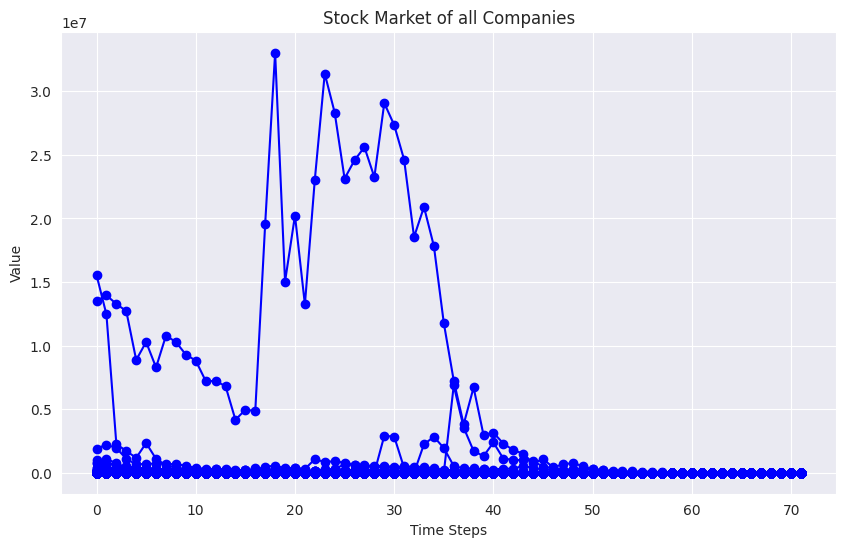

Dataset loaded successfully!


In [4]:
# Load the dataset
DATASET_PATH = "../Dataset/Data/normalized_real_company_stock_dataset_large.csv"
dataset = pd.read_csv(DATASET_PATH)

# Split the existing data set into 3 subset: ideas, statistics and historical
static_columns = [
    col for col in dataset.columns
    if col not in ["tickers", "business_description"] and not col.startswith("month")
]
month_columns = [col for col in dataset.columns if col.startswith("month")]

# These are our 3 subsets
idea_data = dataset["business_description"]
ticker_data = dataset["tickers"]
static_data = dataset[static_columns]
historical_data = dataset[month_columns]

# Ensure numeric data and handle missing values
static_data = static_data.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(float)
historical_data = historical_data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Now split the data using iloc
train_data = historical_data.iloc[:, :60].values.astype(float)
test_data = historical_data.iloc[:, 60:72].values.astype(float)

# Convert to tensors
static_data = torch.tensor(static_data, dtype=torch.float32)
train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

idea_data = idea_data.fillna("")
idea_data_list = idea_data.tolist()

ticker_data = ticker_data.fillna("")
ticker_data_list = ticker_data.tolist()

# Train-test split
train_ideas, test_ideas, train_static, test_static, train_historical, test_historical, train_target, test_target, train_tickers, test_tickers  = train_test_split(
    idea_data_list, static_data, train_data, test_data, ticker_data_list, test_size=0.2, random_state=42
)

# Denormalize the values similarly
predictions_historical = historical_scaler.inverse_transform(historical_data)

plt.figure(figsize=(10, 6))
# Loop through predictions and targets
for i in range(len(predictions_historical)):
    plt.plot(predictions_historical[i], linestyle='-', marker='o', color='blue')  # Plot predictions

# Add labels, title, and legend
plt.xlabel('Time Steps')  # Or whatever your x-axis represents
plt.ylabel('Value')  # Or whatever your y-axis represents
plt.title('Stock Market of all Companies')
plt.grid(True)

# Show the plot
plt.show()

print("Dataset loaded successfully!")

### Define the PyTorch Dataset

This Dataset is used to split the existing Dataset into a Trainingsset and Evaluationset.

In [5]:
class StockDataset(Dataset):
    def __init__(self, idea_data, ticker_data, static_data, historical_data, target_data):
        self.idea_data = idea_data
        self.ticker_data = ticker_data
        self.static_data = torch.tensor(static_data, dtype=torch.float32)
        self.historical_data = torch.tensor(historical_data, dtype=torch.float32)
        self.target_data = torch.tensor(target_data, dtype=torch.float32)

    def __len__(self):
        return len(self.target_data)

    def __getitem__(self, idx):
        # Return the idea (text), static features, historical data, and the target
        return self.idea_data[idx], self.ticker_data[idx], self.static_data[idx], self.historical_data[idx], self.target_data[idx]

# Create a Test and Training Dataset
train_dataset = StockDataset(
    idea_data=train_ideas,
    ticker_data=train_tickers,
    static_data=train_static,
    historical_data=train_historical,
    target_data=train_target
)

test_dataset = StockDataset(
    idea_data=test_ideas,
    ticker_data=test_tickers,
    static_data=test_static,
    historical_data=test_historical,
    target_data=test_target
)

print("Dataset created successfully!")

Dataset created successfully!


/tmp/ipykernel_294013/3922977605.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.static_data = torch.tensor(static_data, dtype=torch.float32)
/tmp/ipykernel_294013/3922977605.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.historical_data = torch.tensor(historical_data, dtype=torch.float32)
/tmp/ipykernel_294013/3922977605.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.target_data = torch.tensor(target_data, dtype=torch.float32)


### Custom Loss Function

For training, we employ a CustomLoss class to calculate the loss between predictions and target data. It is based on the TemporalLoss function, which computes temporal differences in the data and applies them as a penalty. Additionally, we incorporate mean squared error, a penalty for negative predictions, and a penalty for insufficient diversity.

- Parameter 1: Mean-Square-Error
- Parameter 2: Diversity
- Parameter 3: Lamda Smoothness
- Parameter 4: Lamda Penalty
- Parameter 5: MSE Loss


In [6]:
class TemporalLoss(nn.Module):
    def __init__(self, mse_weight=0.6, diversity_weight=0.1, lambda_smooth=0.2, lambda_penalty=0.1, alpha=0.5, beta=0.2):
        super(TemporalLoss, self).__init__()
        self.mse_weight = mse_weight
        self.diversity_weight = diversity_weight
        self.lambda_smooth = lambda_smooth
        self.lambda_penalty = lambda_penalty
        self.alpha = alpha  # Weight for Huber loss
        self.beta = beta    # Weight for volatility penalty
        self.mse_loss = nn.MSELoss()

    def forward(self, predictions, targets):
        # Ensure dimensions match
        if predictions.dim() == 2:
            predictions = predictions.unsqueeze(-1)
        if targets.dim() == 2:
            targets = targets.unsqueeze(-1)

        # Base MSE loss
        mse = self.mse_loss(predictions, targets)

        # Huber loss (for better handling of outliers)
        huber_loss = torch.mean(torch.where(torch.abs(predictions - targets) < self.alpha,
                                            0.5 * (predictions - targets) ** 2,
                                            self.alpha * (torch.abs(predictions - targets) - 0.5 * self.alpha)))

        # Temporal smoothness loss (penalizing large changes between consecutive time steps)
        temporal_diff = (predictions[:, 1:, :] - predictions[:, :-1, :]) / (torch.abs(predictions[:, :-1, :]) + 1e-6)
        smoothness_loss = torch.mean(temporal_diff ** 2)

        # Combine all loss components
        combined_loss = (
                self.mse_weight * mse +
                self.diversity_weight * self.calculate_diversity(predictions) +  # Encouraging diversity in predictions
                self.lambda_smooth * smoothness_loss +
                self.lambda_penalty * self.calculate_negative_penalty(predictions) +
                self.beta * self.calculate_volatility_penalty(predictions) +  # Penalty for volatility
                self.alpha * huber_loss  # Robust to outliers
        )

        return combined_loss

    def calculate_diversity(self, predictions):
        return -torch.std(predictions)

    def calculate_negative_penalty(self, predictions):
        return torch.sum(torch.clamp(-predictions, min=0))

    def calculate_volatility_penalty(self, predictions):
        return torch.mean(torch.abs(predictions[:, 1:, :] - predictions[:, :-1, :]))

### Training the model

Here we import the model and set it up for training

In [7]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, device, epochs=100):

    # Init a scheduler and some variables
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    writer = SummaryWriter(log_dir="logs")  # TensorBoard writer
    train_loss_statistics = []
    test_loss_statistics = []

    # Train the model for a specific number of epochs
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        all_predictions = []
        all_targets = []

        # Get a Batch of Data to train the model
        for idea_data, ticker_data, static_data, historical_data, target_data in train_loader:

            # Move data to the device
            static_data = static_data.to(device)
            historical_data = historical_data.to(device)
            target_data = target_data.to(device)

            # Remove tickers in the current batch from the dataset for retrieval
            excluded_tickers = list(ticker_data)
            removed_tickers = []

            optimizer.zero_grad()

            # Forward pass
            prediction_data = model(
                ideas=idea_data,
                dataset=dataset,
                static_features=static_data,
                historical_data=historical_data,
                use_auxiliary_inputs=True,
                excluded_tickers={i: [ticker] + removed_tickers for i, ticker in enumerate(excluded_tickers)}
            )

            # Calculate the training loss and adjust the model
            loss = criterion(prediction_data, target_data)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # More lenient gradient clipping
            optimizer.step()
            train_loss += loss.item()

            all_predictions.append(prediction_data.cpu().detach().numpy())
            all_targets.append(target_data.cpu().detach().numpy())

        # Flatten the lists to make evaluation easier
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)

        plt.figure(figsize=(10, 6))
        for i in range(len(all_predictions)):
            plt.plot(all_predictions[i], linestyle='-', marker='o', color='blue')  # Plot predictions
            plt.plot(all_targets[i], linestyle='--', marker='x', color='red')  # Plot targets

        plt.xlabel('Months')
        plt.ylabel('Stock Performance')
        plt.title('Predictions vs Targets')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Validation phase
        val_loss, _, _, _ = evaluate(model, validation_loader, device, criterion)
        scheduler.step(val_loss)

        # Logging
        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        train_loss_statistics.append(train_loss)
        test_loss_statistics.append(val_loss)
        writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss}, epoch)

    writer.close()

    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(16, 6))  # Set figure size here
    ax = plt.subplot(1, 2, 2)
    epochs = range(1, len(train_loss_statistics) + 1)
    sns.lineplot(x=epochs, y=train_loss_statistics, label="Train Loss", color='royalblue', ax=ax)
    sns.lineplot(x=epochs, y=test_loss_statistics, label="Test Loss", color='tomato', ax=ax)
    ax.set_xlabel("Epoch", size=14)
    ax.set_ylabel("Loss", size=14)
    ax.set_title("Training Loss / Testing Loss", size=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


### Evaluation

After training we are going to evaluate our model:

In [8]:
def evaluate(model, validation_loader, device, criterion):
    model.eval()  # Set the model to evaluation mode

    validation_loss = 0.0
    all_predictions = []
    all_targets = []
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for idea_data, ticker_data, static_data, historical_data, target_data in validation_loader:

            # Move data to the device
            static_data = static_data.to(device)
            historical_data = historical_data.to(device)
            target_data = target_data.to(device)

            # Forward pass
            prediction_data = model(
                ideas=idea_data,
                dataset=dataset,
                use_auxiliary_inputs=False
            )

            # Compute temporal loss
            loss = criterion(prediction_data, target_data)
            validation_loss += loss.item()

            all_predictions.append(prediction_data.cpu().numpy())
            all_targets.append(target_data.cpu().numpy())


    # Average validation loss
    validation_loss /= len(validation_loader)
    print(f"Validation Loss: {validation_loss}")

    # Flatten the lists to make evaluation easier
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Denormalize the values similarly
    predictions_historical = all_predictions
    targets_historical = all_targets

    plt.figure(figsize=(10, 6))

    # Loop through predictions and targets
    for i in range(len(predictions_historical)):
        plt.plot(predictions_historical[i], linestyle='-', marker='o', color='blue')  # Plot predictions
        plt.plot(targets_historical[i], linestyle='--', marker='x', color='red')  # Plot targets

    # Add labels, title, and legend
    plt.xlabel('Time Steps')  # Or whatever your x-axis represents
    plt.ylabel('Value')  # Or whatever your y-axis represents
    plt.title('Predictions vs Targets')
    plt.legend()  # Add legend to differentiate between predictions and targets
    plt.grid(True)

    # Show the plot
    plt.show()

    # Calculate MSE and MAE for historical features
    mse_historical = mean_squared_error(predictions_historical, targets_historical)
    mae_historical = mean_absolute_error(targets_historical, predictions_historical)
    r2_historical = r2_score(targets_historical, predictions_historical)

    # Print metrics for each section
    print(f"MSE for historical features: {mse_historical}")
    print(f"MAE for historical features: {mae_historical}")
    print(f"R² for historical features: {r2_historical}")

    # Draw some plot to evaluate the results
    plt.scatter(all_targets, all_predictions, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted")
    plt.show()

    residuals = all_targets - all_predictions
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.title("Residual Distribution")
    plt.show()

    return validation_loss, mse_historical, mae_historical, r2_historical


### Run the Training Loop

In [9]:
# PredictionModel initialization
INPUT_PATH = "../RetrievalSystem/Embeddings/embeddings.csv"

current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Cuda is available!")

# Initialize the model - HAVE TO BE ADAPTED TO DATASET (Values are likely correct)
static_feature_dim_num = static_data.shape[1]    # Number of static features
historical_dim_num = 72       # Number of historical stock performance points
hidden_dim_num = 128          # Hidden layer size
forecast_steps_num = 12       # Predict next 12 months
retrieval_num = 10

retrieval_system = RetrievalSystem(INPUT_PATH, retrieval_number=retrieval_num)
model = RetrievalAugmentedPredictionModel(
    forecast_steps=forecast_steps_num,
    ret_sys=retrieval_system,
    static_dim=static_feature_dim_num,
    historical_dim=historical_dim_num, # THIS IS IMPORTANT
    retrieval_number=retrieval_num
)
model.to(current_device)

# Create DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

validation_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
temporal_loss = TemporalLoss(lambda_smooth=0.1)
# temporal_loss = torch.nn.SmoothL1Loss(beta=1)

print("=== Start Training ===")
train_model(model, train_loader, validation_loader, temporal_loss, optimizer, current_device, epochs=10)

print("=== Save Trained RAPModel ===")
torch.save(model, 'trained_model.pth')

print(" > Done Training the RAPModel")

=== Start Training ===
Retrieved tickers:  [array(['MDRX', 'ICLR', 'AEI', 'HCTI', 'SYRA', 'TEM', 'CCLD', 'CCLDO',
       'CCLDP', 'STRM'], dtype=object), array(['INAQW', 'INTE', 'IRAA', 'ATEK', 'AIB', 'AACT', 'BEAGU', 'GODN',
       'WAVS', 'ATMV'], dtype=object), array(['CYBN', 'ATAI', 'PBM', 'CMND', 'VTGN', 'ENVB', 'SILO', 'ATNF',
       'PXMD', 'EXAI'], dtype=object), array(['ALAB', 'VERI', 'ALIT', 'BNAI', 'PHUN', 'PATH', 'NSIT', 'NOW',
       'APPN', 'DUOT'], dtype=object), array(['WBIG', 'WBIL', 'AIVL', 'FM', 'DEEF', 'KLDW', 'FILL', 'RIGS',
       'VAMO', 'HDGE'], dtype=object), array(['AQUNU', 'PRLH', 'DIST', 'GMFI', 'IVCB', 'IVCBU', 'QETA', 'CMCA',
       'YOTA', 'INTE'], dtype=object), array(['SANA', 'TAK', 'UTHR', 'MRK', 'REGN', 'TWST', 'TNXP', 'XBIO',
       'NTLA', 'CASI'], dtype=object), array(['CGEN', 'APLS', 'PGEN', 'CHRS', 'AUTL', 'RCUS', 'IMAB', 'MREO',
       'INCY', 'BCYC'], dtype=object), array(['APXI', 'ISRL', 'ISRLU', 'IMAQ', 'MCAA', 'SVII', 'QOMO', 'AQUNU',
      

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7735de5c98a0>
Traceback (most recent call last):
  File "/home/kai/Documents/AIR-Project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/kai/Documents/AIR-Project/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
 

KeyboardInterrupt: 